# Aprendizado de Máquina para precificação de carros
### Autor:

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer

In [3]:
# Carregando os dados:
df = pd.read_csv("CAR DETAILS FROM CAR DEKHO.csv")

In [5]:
# Verificando se há nulos:
print(df.isnull().sum())

# Verificando os tipos de dados:
print(df.dtypes)

name             0
year             0
selling_price    0
km_driven        0
fuel             0
seller_type      0
transmission     0
owner            0
dtype: int64
name             object
year              int64
selling_price     int64
km_driven         int64
fuel             object
seller_type      object
transmission     object
owner            object
dtype: object


Os dados parecem estar padronizados. Mesmo assim, executarei algumas ações de saneamento nos dados para garantir.

In [8]:
# Limpeza e tratamento dos dados:
df = df.drop_duplicates() # Remove linhas duplicadas.

# Extrainodo a marca e modelo do carro:
df.loc[:, 'car_brand'] = df['name'].apply(lambda x: x.split()[0])
df.loc[:, 'car_model'] = df['name'].apply(lambda x: ' '.join(x.split()[1:]))
df = df.drop(columns='name') # Removendo a coluna original.

# Padronizando as colunas de texto (variáveis categóricas):
df['fuel'] = df['fuel'].str.strip().str.lower().str.capitalize()
df['seller_type'] = df['seller_type'].str.strip().str.lower().str.capitalize()
df['transmission'] = df['transmission'].str.strip().str.lower().str.capitalize()

# Mapeando a coluna 'owner' para números:
owner_mapping = {
    'First Owner': 1,
    'Second Owner': 2,
    'Third Owner': 3,
    'Fourth & Above Owner': 4,
    'Test Drive Car': 0
}
df['owner'] = df['owner'].map(owner_mapping)

# Reduz cardinalidade de 'car_model'
model_counts = df['car_model'].value_counts()
model_thresh = 30  # limite mínimo de frequência
model_top = model_counts[model_counts >= model_thresh].index

df['car_model'] = df['car_model'].apply(lambda x: x if x in model_top else 'Outros')

### Análise Exploratória
Antes de fazer a regressão linear, preferi fazer uma análise exploratória no conjunto de dados. Sendo assim, fiz alguns gráficos, como histogramas e boxplots, além da matriz de correlação entre as variáveis numéricas.


In [11]:
sns.set(style="whitegrid")

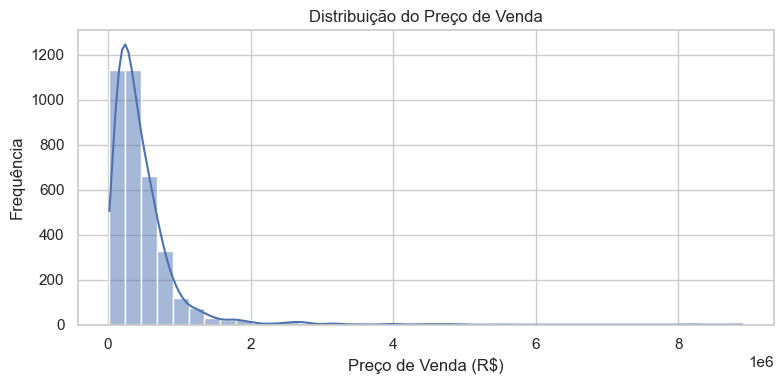

In [13]:
# Histograma dos preços:
plt.figure(figsize=(8, 4))
sns.histplot(df['selling_price'], bins=40, kde=True)
plt.title('Distribuição do Preço de Venda')
plt.xlabel('Preço de Venda (R$)')
plt.ylabel('Frequência')
plt.tight_layout()
plt.show()

Como podemos perceber acima, a distribuição dos preços se concentra no intervalo de 500 mil a 2 milhões. Existem valores acima de **2mi**, mas podem ser ***outliers***.

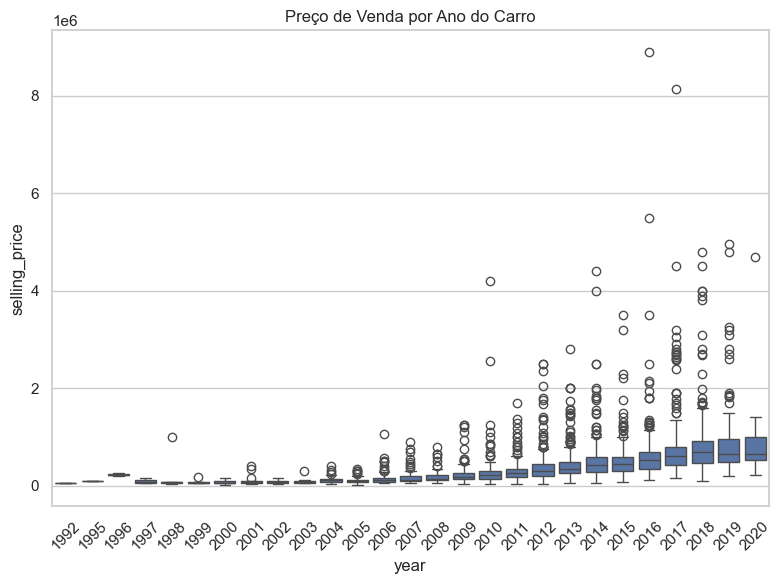

In [16]:
# Boxplot dos preços de venda por ano do carro:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='year', y='selling_price')
plt.xticks(rotation=45)
plt.title('Preço de Venda por Ano do Carro')
plt.tight_layout()
plt.show()

Perceba que:<br>(1) Carros mais velhos têm preços menores e mais parecidos entre si;<br>(2) Carros mais novos têm valores mais altos e com grandes variações entre si;<br>(3) Por último, carros de idade intermediária têm preços intermediários, mas com grandes variações entre si.

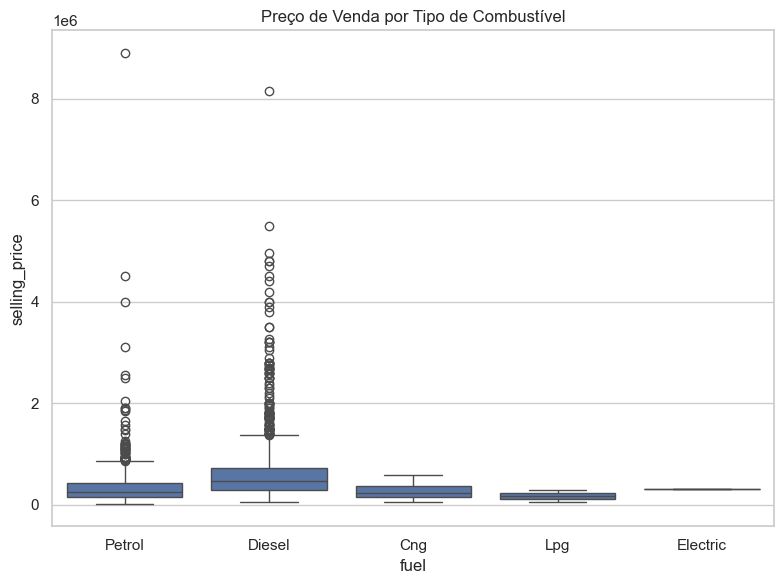

In [19]:
# Boxplot do preço de venda por tipo de combustível:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='fuel', y='selling_price')
plt.title('Preço de Venda por Tipo de Combustível')
plt.tight_layout()
plt.show()

Observamos que:
<br>(1) Carros a Diesel são os mais caros;
<br>(2) Carros a gasolina têm preços medianos;
<br>(3) Carros elétricos são os mais baratos, com preços bem parecidos entre si.

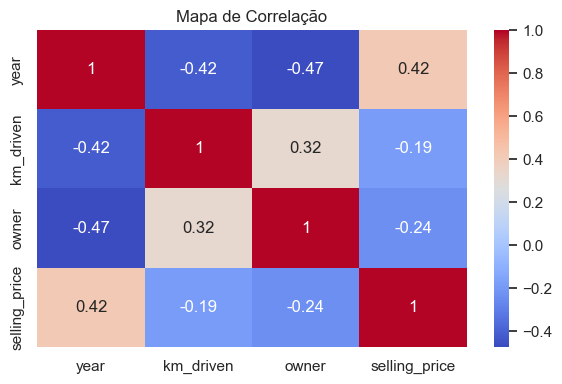

In [22]:
# Matriz de correlação das variáveis:
plt.figure(figsize=(6, 4))
corr = df[['year', 'km_driven', 'owner', 'selling_price']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Mapa de Correlação')
plt.tight_layout()
plt.show()

Pela matriz de correlação, temos:
<br>(1) ***selling_price*** vs. ***year***: correlação positiva, ou seja, carros mais novos são mais caros.
<br>(2) ***selling_price*** vs. ***km_driven***: correlação negativa, ou seja, carros com menor quilometragem são mais caros.
<br>(3) ***selling_price*** vs. ***owner***: correlação negativa, ou seja, carros com mais donos são mais baratos.
<br>(4) ***year*** vs. ***km_driven***: correlação negativa, ou seja, carros mais novos têm menor quilometragem.
<br>(5) ***year*** vs. ***owner***: correlação negativa, ou seja, carros mais novos geralmente estão com o primeiro dono.
<br>(6) ***owner*** vs. ***km_driven***: correlação positiva, ou seja, carros com maior quilometragem têm mais donos.

### Regressão Linear com K-Folds
Agora é hora de fazer a regressão linear, a fim de ajustar as variáveis e encontrar as tendências de preço. Para isso, usarei a técnica de K-Folds, que é uma forma de validação cruzada.
<br>
Nesse método, os dados são divididos em K partes (ou *folds*) aproximadamente iguais. O modelo é treinado K vezes, cada vez utilizando um dos *folds* como conjunto de teste e os K-1 restantes como conjunto de treino.
<br>
A variável dependente, logicamente, será o **selling_price**, que vai depender das outras variáveis.

In [26]:
# Defino as variáveis independentes (X) e a variável dependente (y):
X = df.drop('selling_price', axis=1)
y = df['selling_price']

# Defino as colunas categóricas e as colunas numéricas:
categorical_cols = ['fuel', 'seller_type', 'transmission', 'car_brand', 'car_model']
numerical_cols = ['year', 'km_driven', 'owner']

# Garante que todas as colunas categóricas estão como string e sem valores nulos
for col in categorical_cols:
    X[col] = X[col].fillna('Desconhecido').astype(str)

# Garante que colunas numéricas também não têm NaN
for col in numerical_cols:
    X[col] = X[col].fillna(X[col].median())

# Pré-processamento com imputação e codificação
cat_imputer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Desconhecido')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Pré-processamento com imputação e codificação
cat_imputer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Desconhecido')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

num_imputer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

preprocessor = ColumnTransformer([
    ('cat', cat_imputer, categorical_cols),
    ('num', num_imputer, numerical_cols)
])

# Pipeline com pré-processamento + regressão linear
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Validação cruzada com 5 divisões (folds), mantendo uma proporção de 80% dos dados para treino e 20% para teste a cada iteração:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
mse_scores = []
rmse_scores = []

# Executa o K-Fold:
for train_idx, test_idx in kf.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    mse_scores.append(mse)
    rmse_scores.append(rmse)

# Exibe resultados
print("MSE por fold:", np.round(mse_scores, 2))
print("Média do MSE:", round(np.mean(mse_scores), 2))
print("Desvio padrão do MSE:", round(np.std(mse_scores), 2))
print("\nRMSE médio:", round(np.mean(rmse_scores), 2))

MSE por fold: [1.86766550e+11 8.66209041e+10 1.08143040e+11 1.69856486e+11
 1.35532867e+11]
Média do MSE: 137383969268.12
Desvio padrão do MSE: 37224859803.13

RMSE médio: 367122.94


Como podemos ver acima, o resultado da 1a regressão foi horrível, pois, estamos errando cerca de R$367k por carro!
Como o feature scalling já foi feito (usando standard scalling), vou partir para outra abordagem: identificar e tratar os possíveis outliers.

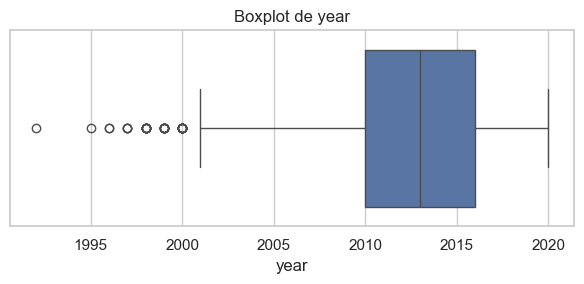

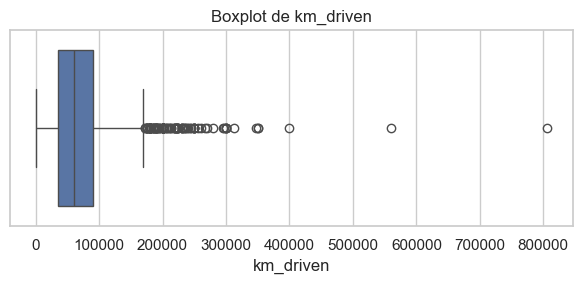

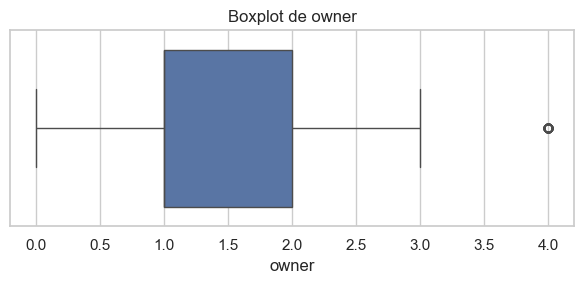

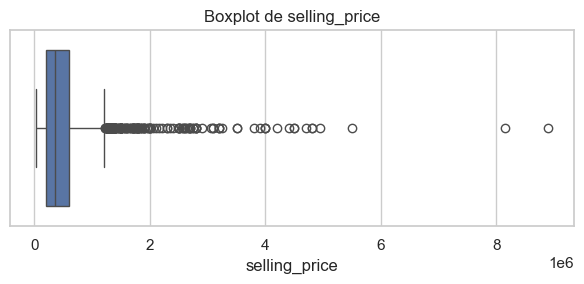

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

numerical_cols = ['year', 'km_driven', 'owner', 'selling_price']

for col in numerical_cols:
    plt.figure(figsize=(6, 3))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot de {col}')
    plt.tight_layout()
    plt.show()

<div style='text-align:justify'>Perceba que os atributos <b>selling_price</b>, <b>km_driven</b> e <b>year</b> possuem muitos outliers. Para tratá-los, usarei a técnica de IQR (Interquartile Range), que identifica valores extremos com base na dispersão dos dados. Essa técnica considera como outliers os valores que estão abaixo do primeiro quartil (Q1) menos 1,5 vezes o intervalo interquartil (IQR) ou acima do terceiro quartil (Q3) mais 1,5 vezes o IQR. Esses valores são então removidos para evitar distorções na análise.</div>

In [35]:
def remover_outliers_iqr(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    return df[(df[col] >= limite_inferior) & (df[col] <= limite_superior)]

# Aplica o filtro para as colunas numéricas principais (exceto 'year', que costuma ser categórica)
for col in ['selling_price', 'km_driven']:
    df = remover_outliers_iqr(df, col)

print("Novas dimensões do dataset após remoção de outliers:", df.shape)

Novas dimensões do dataset após remoção de outliers: (3287, 9)


In [37]:
# Agora, vou reexecutar o pipeline de regressão:

# Defino as variáveis independentes (X) e a variável dependente (y):
X = df.drop('selling_price', axis=1)
y = df['selling_price']

# Defino as colunas categóricas e as colunas numéricas:
categorical_cols = ['fuel', 'seller_type', 'transmission', 'car_brand', 'car_model']
numerical_cols = ['year', 'km_driven', 'owner']

# Garante que todas as colunas categóricas estão como string e sem valores nulos
for col in categorical_cols:
    X[col] = X[col].fillna('Desconhecido').astype(str)

# Garante que colunas numéricas também não têm NaN
for col in numerical_cols:
    X[col] = X[col].fillna(X[col].median())

# Pré-processamento com imputação e codificação
cat_imputer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Desconhecido')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Pré-processamento com imputação e codificação
cat_imputer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Desconhecido')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

num_imputer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

preprocessor = ColumnTransformer([
    ('cat', cat_imputer, categorical_cols),
    ('num', num_imputer, numerical_cols)
])

# Pipeline com pré-processamento + regressão linear
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Validação cruzada com 5 divisões (folds), mantendo uma proporção de 80% dos dados para treino e 20% para teste a cada iteração:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
mse_scores = []
rmse_scores = []

# Executa o K-Fold:
for train_idx, test_idx in kf.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    mse_scores.append(mse)
    rmse_scores.append(rmse)

# Exibe resultados
print("MSE por fold:", np.round(mse_scores, 2))
print("Média do MSE:", round(np.mean(mse_scores), 2))
print("Desvio padrão do MSE:", round(np.std(mse_scores), 2))
print("\nRMSE médio:", round(np.mean(rmse_scores), 2))

MSE por fold: [2.66994254e+10 2.52817168e+10 2.63059492e+10 2.76188594e+10
 2.50993671e+10]
Média do MSE: 26201063578.22
Desvio padrão do MSE: 930424018.91

RMSE médio: 161841.99


In [39]:
df['selling_price'].mean()

392734.76483115304

Apesar de ter apresentado uma melhoria significativa, o valor de RMSE ainda está alto (~42% da média de **selling_price**). Portanto, vou criar um novo atributo chamado **car_age**, para lidar com números menores no modelo.

In [48]:
# Criando a coluna car_age:
df['car_age'] = 2025 - df['year']

In [84]:
# Atualizando o pipeline com a nova variável:

# Define variáveis independentes (X) e dependente (y)
X = df.drop('selling_price', axis=1)
y = df['selling_price']

# Define colunas categóricas e numéricas (não inclui 'year', mas inclui 'car_age')
categorical_cols = ['fuel', 'seller_type', 'transmission', 'car_brand', 'car_model']
numerical_cols = ['km_driven', 'owner', 'car_age']  # Não inclui 'year'

# Garante que todas as colunas categóricas estão como string e sem valores nulos
for col in categorical_cols:
    X[col] = X[col].fillna('Desconhecido').astype(str)

# Garante que colunas numéricas também não têm NaN
for col in numerical_cols:
    X[col] = X[col].fillna(X[col].median())

# Pré-processamento com imputação e codificação
cat_imputer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Desconhecido')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

num_imputer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('cat', cat_imputer, categorical_cols),
    ('num', num_imputer, numerical_cols)
])

# Pipeline com pré-processamento + regressão linear
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Validação cruzada com 5 divisões (folds)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
mse_scores = []
rmse_scores = []

# Executa o K-Fold
for train_idx, test_idx in kf.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    mse_scores.append(mse)
    rmse_scores.append(rmse)

# Exibe os resultados
print("MSE por fold:", np.round(mse_scores, 2))
print("Média do MSE:", round(np.mean(mse_scores), 2))
print("Desvio padrão do MSE:", round(np.std(mse_scores), 2))
print("\nRMSE médio:", round(np.mean(rmse_scores), 2))

MSE por fold: [2.44956337e+10 2.29506834e+10 2.29972890e+10 2.49663753e+10
 2.31020658e+10]
Média do MSE: 23702409432.23
Desvio padrão do MSE: 854343469.75

RMSE médio: 153931.07


Como podemos perceber, a diferença ao adotar **car_age** como parâmetro no lugar de **year** não foi significativa. Agora, irei testar outras técnicas de regressão, pois a regressão linear não parece estar dando conta do problema.


MSE: 20702684845.70
RMSE: 143884.28


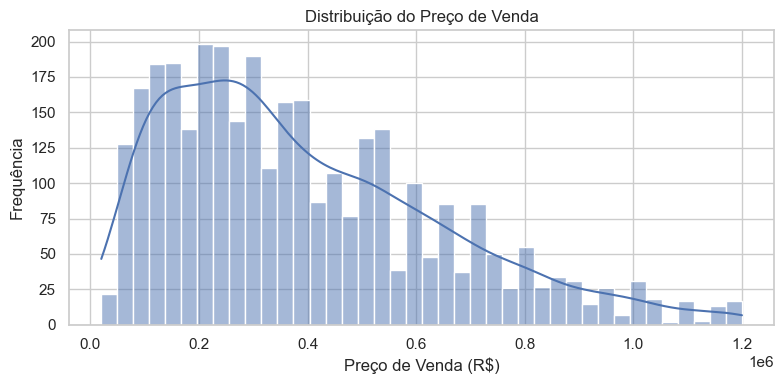

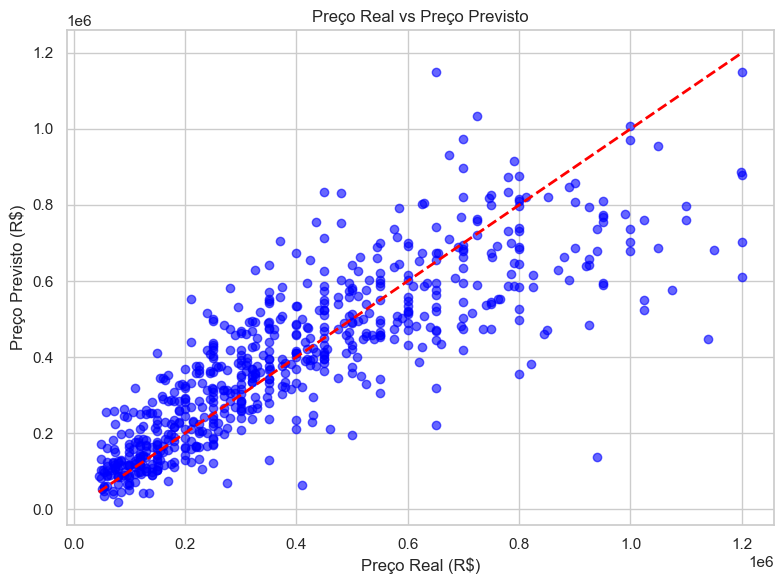

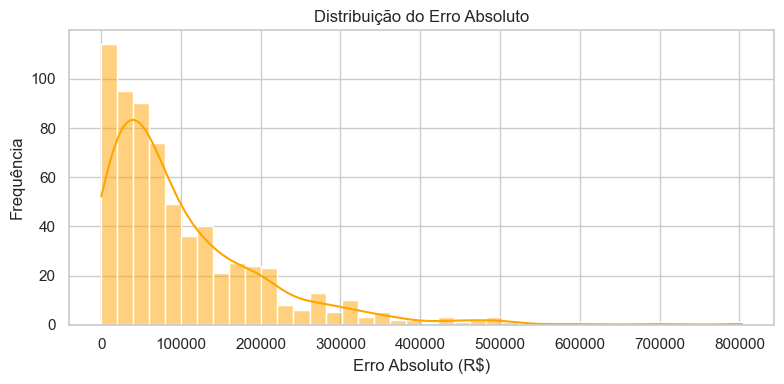

In [96]:
# Vou fazer uma regressão polinomial, e vou testar os graus até achar um bom valor, que consiga ajustar bem os dados, sem over-fitting:

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import numpy as np

# Definindo o grau da regressão polinomial
degree = 2 # Ajuste para o grau que desejar

# Transformador polinomial
polynomial_transformer = PolynomialFeatures(degree=degree, include_bias=False)

# Pré-processamento das variáveis numéricas e categóricas
num_imputer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

cat_imputer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Desconhecido')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Pré-processador
preprocessor = ColumnTransformer([
    ('num', num_imputer, ['year', 'km_driven', 'owner']),
    ('cat', cat_imputer, ['fuel', 'seller_type', 'transmission', 'car_brand', 'car_model'])
])

# Pipeline com transformação polinomial e regressão linear
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('polynomial', polynomial_transformer),  # Transformação polinomial
    ('regressor', LinearRegression())  # Regressão Linear
])

# Divisão dos dados
X = df.drop('selling_price', axis=1)
y = df['selling_price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ajustando o modelo
pipeline.fit(X_train, y_train)

# Fazendo as previsões
y_pred = pipeline.predict(X_test)

# Cálculo do erro quadrático médio (MSE) e erro quadrático médio da raiz (RMSE)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Exibindo os resultados
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")

# Visualizando a distribuição dos preços de venda
plt.figure(figsize=(8, 4))
sns.histplot(df['selling_price'], bins=40, kde=True)
plt.title('Distribuição do Preço de Venda')
plt.xlabel('Preço de Venda (R$)')
plt.ylabel('Frequência')
plt.tight_layout()
plt.show()

# Visualizando o gráfico de dispersão entre preço real e preço previsto
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', lw=2, linestyle='--')  # Linha de igualdade
plt.title('Preço Real vs Preço Previsto')
plt.xlabel('Preço Real (R$)')
plt.ylabel('Preço Previsto (R$)')
plt.tight_layout()
plt.show()

# Visualizando o erro absoluto
plt.figure(figsize=(8, 4))
sns.histplot(np.abs(y_test - y_pred), bins=40, kde=True, color='orange')
plt.title('Distribuição do Erro Absoluto')
plt.xlabel('Erro Absoluto (R$)')
plt.ylabel('Frequência')
plt.tight_layout()
plt.show()

Após diversos testes, percebi que o menor erro possível era usando um polinômio de grau 2 e RobustScaler (o RobustScaler melhora muito pouco, mas qualquer melhoria é bem vinda). 
Sendo assim, a regressão linear mais acurada é em grau 2.

In [105]:
# Teste:

novo_carro = pd.DataFrame([{
    'year': 2016,
    'km_driven': 11958,
    'fuel': 'Petrol',
    'seller_type': 'Dealer',
    'transmission': 'Manual',
    'owner': 1,
    'car_brand': 'Honda',
    'car_model': 'Amaze S i-VTEC'
}])

preco_previsto = pipeline.predict(novo_carro)
print(f"Preço previsto: R$ {preco_previsto[0]:,.2f}")

Preço previsto: R$ 574,604.06


O preço real do veículo acima é R$495K. Sendo assim, poderíamos dizer que a previsão foi razoável, errou menos de 16%. No entanto, 16% não é um valor baixo, e ainda por cima, o erro foi menor pois este carro tem um valor próximo da média. Dessa forma, acredito que, se quisesse ter um modelo preditivo melhor, teria que descartar os dados mais dispersos. Ou seja, o conceito de outlier teria que ser aumentado, para que mais dados fossem descartados e assim, o modelo acertasse mais.

In [110]:
df['selling_price'].mean()

392734.76483115304